# Quantum Generative Adversarial Network (QGAN) for Time Series Data

This notebook implements a Quantum GAN using PennyLane to analyze and generate time series data from Optical Density (OD) measurements. We'll build this implementation step by step, explaining each component along the way.

## Setup and Imports


In [ ]:
# Install required packages
!pip install pennylane torch torchvision pandas numpy matplotlib seaborn scipy statsmodels


In [2]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, wasserstein_distance, probplot
from scipy.special import lambertw
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import time
import numpy as np


# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# PennyLane imports
import pennylane as qml

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


## Data Loading and Preprocessing

First, we'll load our Optical Density (OD) time series data and perform initial visualization and preprocessing steps.


Data shape (total measurements): torch.Size([778])


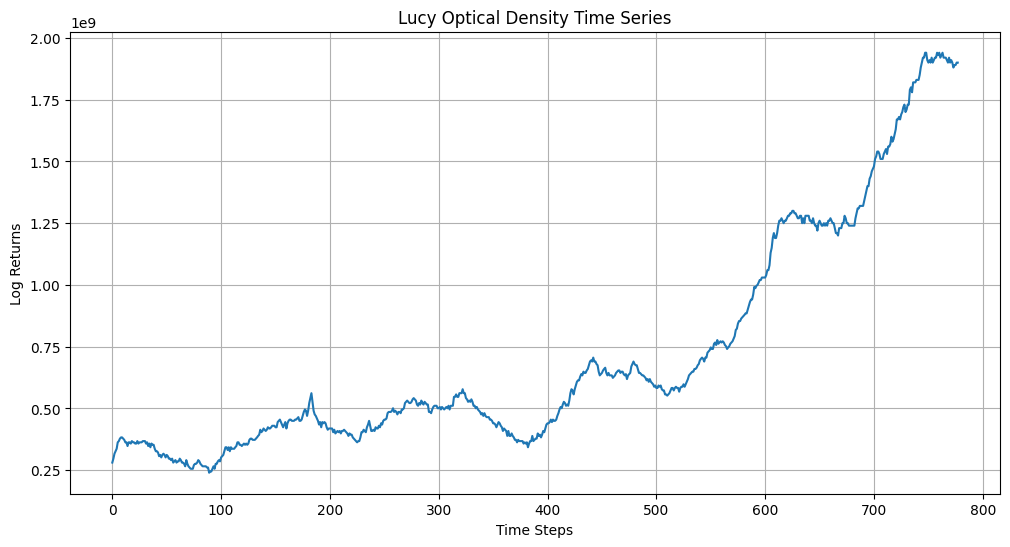


Basic data statistics:
count    7.780000e+02
mean     7.219640e+08
std      4.573705e+08
min      2.400000e+08
25%      4.090000e+08
50%      5.270000e+08
75%      8.850000e+08
max      1.940000e+09
Name: value, dtype: float64


In [3]:
# Load and preprocess the data
lucy = pd.read_csv('lucy2.csv', header=None, names=['value'])

# Convert string values to float, replacing any non-numeric values with NaN
lucy['value'] = pd.to_numeric(lucy['value'], errors='coerce')

# Fill missing values with rolling mean
lucy['value'] = lucy['value'].fillna(lucy['value'].rolling(window=10, min_periods=1).mean())

# Drop any remaining NaN values
lucy = lucy.dropna()

# Convert to tensor
OD = torch.tensor(lucy['value'].values, dtype=torch.float32)

print('Data shape (total measurements):', OD.shape)

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(OD.numpy())
plt.title('Lucy Optical Density Time Series')
plt.xlabel('Time Steps')
plt.ylabel('Log Returns')
plt.grid(True)
plt.show()

# Display some basic statistics
print('\nBasic data statistics:')
print(lucy['value'].describe())


## Returns Analysis

Let's calculate and visualize both direct returns and logarithmic returns of our time series.


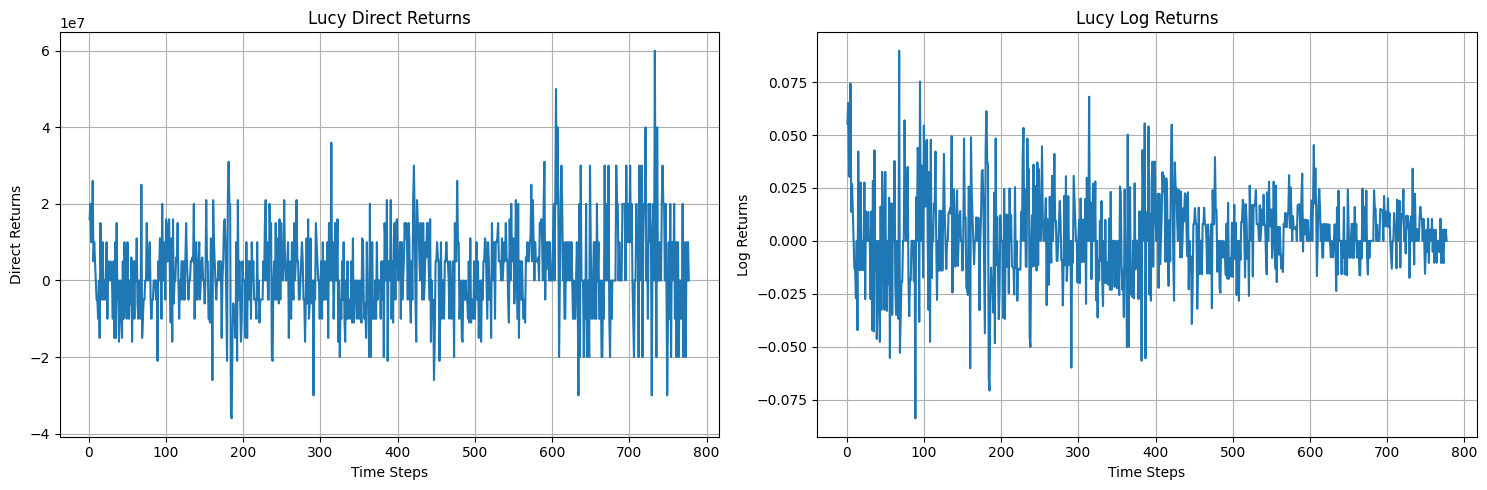


Direct Returns Statistics:
Mean: 2083655.1250
Std: 11912895.0000
Min: -36000000.0000
Max: 60000000.0000
Skewness: 0.3014
Kurtosis: 1.0530

Log Returns Statistics:
Mean: 0.0025
Std: 0.0211
Min: -0.0839
Max: 0.0898
Skewness: 0.0066
Kurtosis: 1.3363


In [4]:
# Create time index for plotting
time_index = np.arange(len(OD))

# Calculate returns
# Direct returns over time
lucy_returns = OD[1:] - OD[:-1]

# Logarithmic returns over time
lucy_log_returns = torch.log(OD[1:]) - torch.log(OD[:-1])

# Convert to numpy for plotting
returns_np = lucy_returns.numpy()
log_returns_np = lucy_log_returns.numpy()

# Plot the graphs side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Plot direct returns
axes[0].plot(time_index[1:], returns_np)
axes[0].set_title('Lucy Direct Returns')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Direct Returns')
axes[0].grid(True)

# Plot log returns
axes[1].plot(time_index[1:], log_returns_np)
axes[1].set_title('Lucy Log Returns')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Log Returns')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print basic statistics of returns
print("\nDirect Returns Statistics:")
print(f"Mean: {np.mean(returns_np):.4f}")
print(f"Std: {np.std(returns_np):.4f}")
print(f"Min: {np.min(returns_np):.4f}")
print(f"Max: {np.max(returns_np):.4f}")
print(f"Skewness: {stats.skew(returns_np):.4f}")
print(f"Kurtosis: {stats.kurtosis(returns_np):.4f}")

print("\nLog Returns Statistics:")
print(f"Mean: {np.mean(log_returns_np):.4f}")
print(f"Std: {np.std(log_returns_np):.4f}")
print(f"Min: {np.min(log_returns_np):.4f}")
print(f"Max: {np.max(log_returns_np):.4f}")
print(f"Skewness: {stats.skew(log_returns_np):.4f}")
print(f"Kurtosis: {stats.kurtosis(log_returns_np):.4f}")

# Save log returns for later use
log_returns_data = log_returns_np


## Data Analysis

Let's analyze the statistical properties of our data to better understand what we're working with.


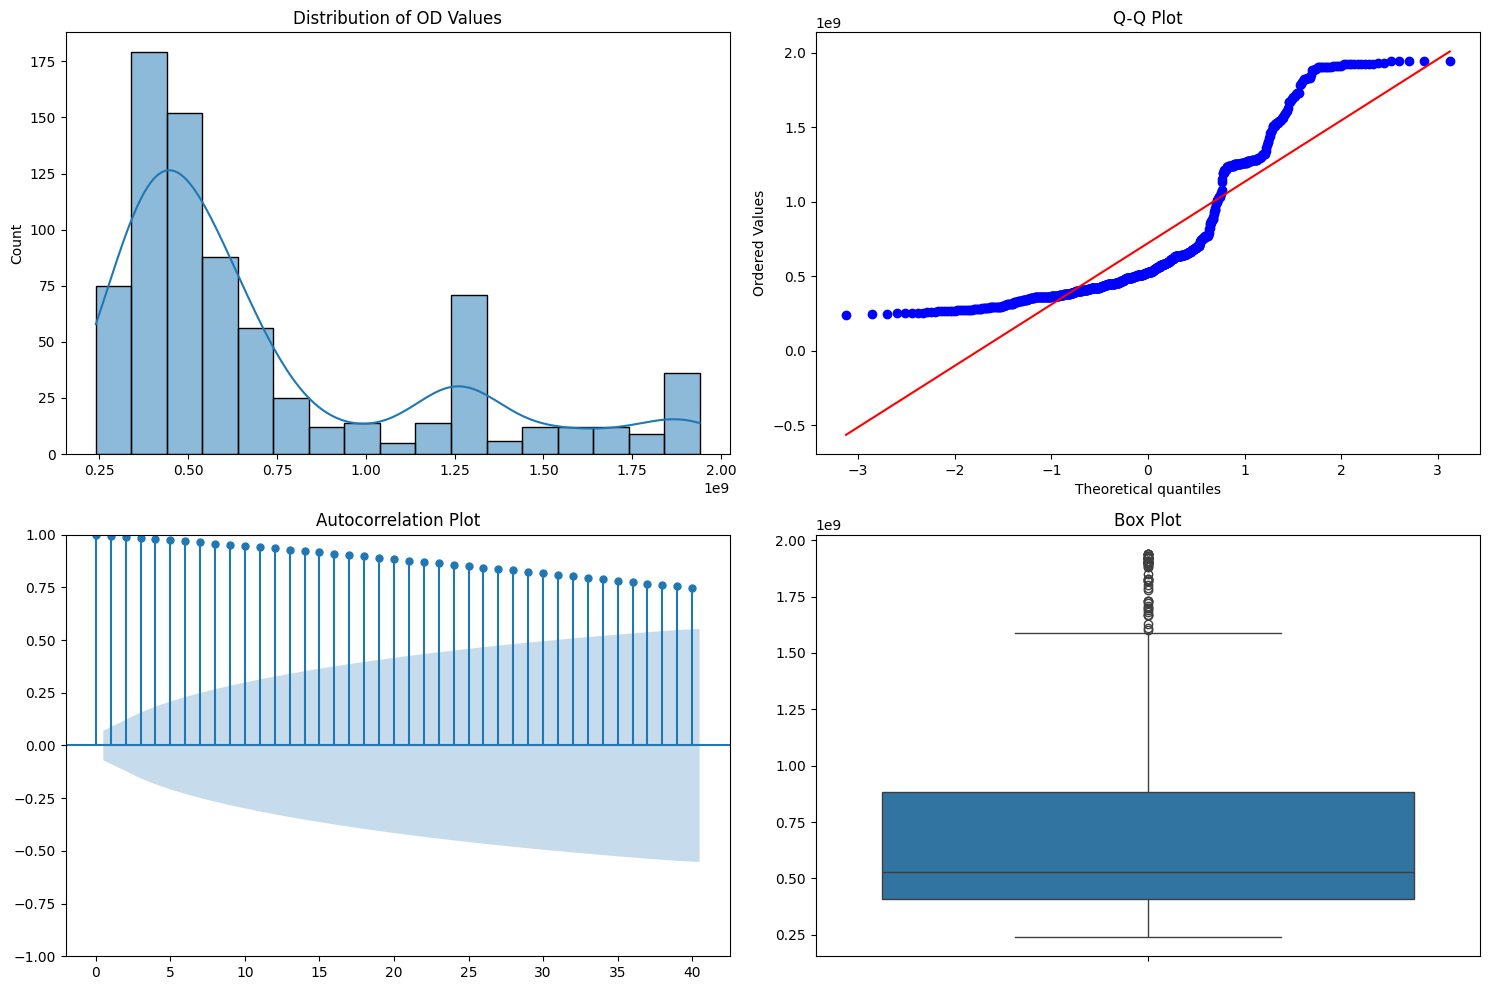


Basic Statistics:
Mean: 721964032.0000
Std: 457076448.0000
Min: 240000000.0000
Max: 1940000000.0000
Skewness: 1.3044
Kurtosis: 0.5516


In [6]:
# Statistical analysis of the data
data = OD.numpy()

# Create subplots for different visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram with KDE
sns.histplot(data=data, kde=True, ax=axes[0,0])
axes[0,0].set_title('Distribution of OD Values')

# Q-Q plot
stats.probplot(data, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot')

# Autocorrelation plot
sm.graphics.tsa.plot_acf(data, lags=40, ax=axes[1,0])
axes[1,0].set_title('Autocorrelation Plot')

# Box plot
sns.boxplot(data=data, ax=axes[1,1])
axes[1,1].set_title('Box Plot')

plt.tight_layout()
plt.show()

# Print basic statistics
print('\nBasic Statistics:')
print(f'Mean: {np.mean(data):.4f}')
print(f'Std: {np.std(data):.4f}')
print(f'Min: {np.min(data):.4f}')
print(f'Max: {np.max(data):.4f}')
print(f'Skewness: {stats.skew(data):.4f}')
print(f'Kurtosis: {stats.kurtosis(data):.4f}')


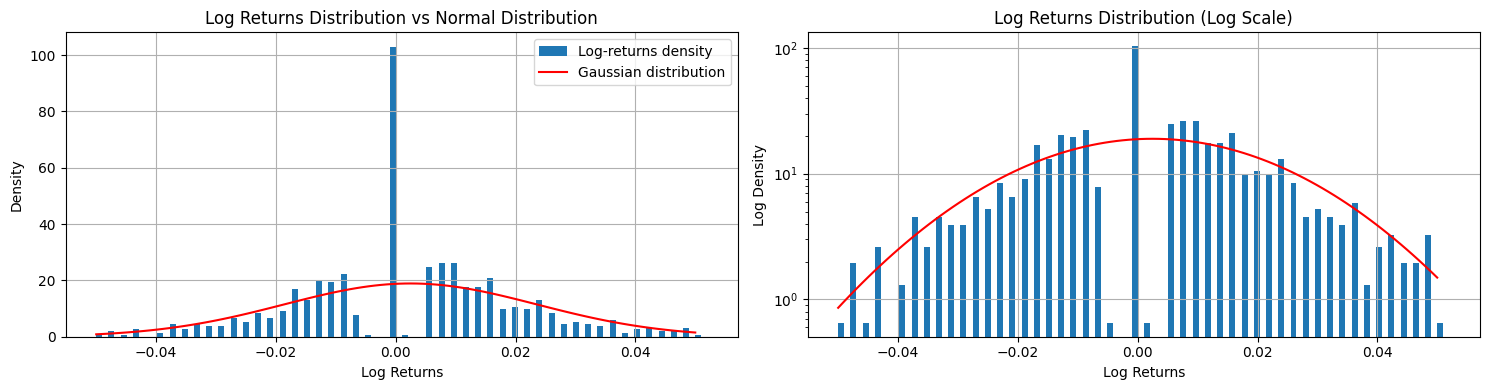


Log Returns Statistics:
Mean: 0.0025
Standard Deviation: 0.0211
Skewness: 0.0066
Kurtosis: 1.3363


In [7]:
# Analyze the distribution of log returns
# Convert PyTorch tensor to numpy array for plotting
lucy_log_returns_np = lucy_log_returns.numpy()

# plot the graphs side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

# density of log-returns
bin_edges = np.linspace(-0.05, 0.05, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
axes[0].hist(lucy_log_returns_np, bins=bin_edges, density=True, width=0.001, label='Log-returns density')
axes[0].grid()

# normal distribution with same mean and standard deviation as log-returns
mu = np.mean(lucy_log_returns_np)
sigma = np.std(lucy_log_returns_np)

# Generate a set of points x
x = np.linspace(-0.05, 0.05, 100)

# Generate the Gaussian PDF for the points x with same mean and standard deviation as the log-returns
pdf = norm.pdf(x, mu, sigma)

# plot the Gaussian PDF
axes[0].plot(x, pdf, 'r', label='Gaussian distribution')
axes[0].legend()
axes[0].set_title('Log Returns Distribution vs Normal Distribution')
axes[0].set_xlabel('Log Returns')
axes[0].set_ylabel('Density')

# plot in logarithmic scale
axes[1].hist(lucy_log_returns_np, bins=bin_edges, density=True, width=0.001, log=True)
axes[1].grid()
axes[1].set_title('Log Returns Distribution (Log Scale)')
axes[1].set_xlabel('Log Returns')
axes[1].set_ylabel('Log Density')

# plot the Gaussian PDF in logarithmic scale
axes[1].semilogy(x, pdf, 'r')

plt.tight_layout()
plt.show()

# Print some statistics about the log returns
print("\nLog Returns Statistics:")
print(f"Mean: {mu:.4f}")
print(f"Standard Deviation: {sigma:.4f}")
print(f"Skewness: {stats.skew(lucy_log_returns_np):.4f}")
print(f"Kurtosis: {stats.kurtosis(lucy_log_returns_np):.4f}")


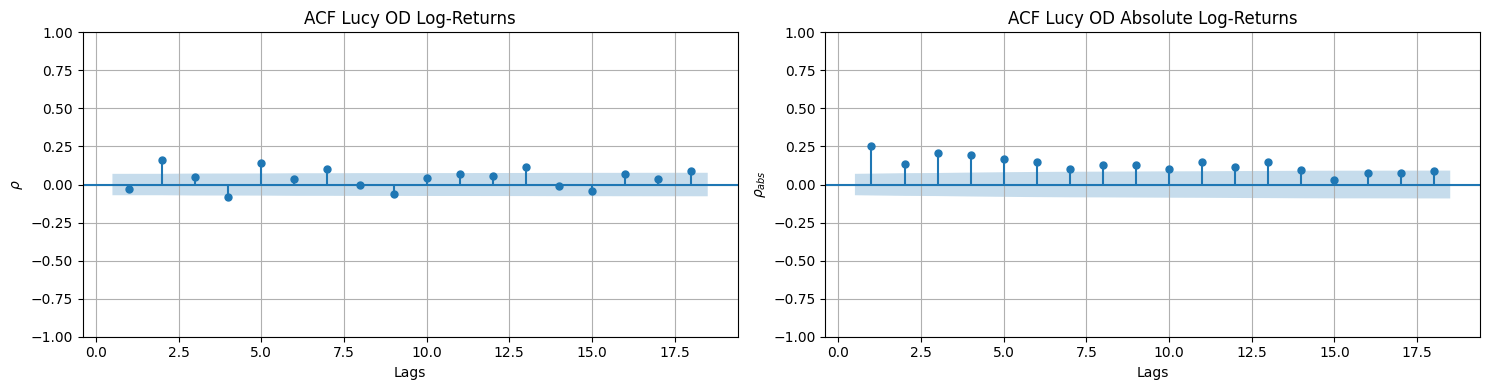


Autocorrelation Statistics:
First-order autocorrelation of log returns: -0.0300
First-order autocorrelation of absolute log returns: 0.2500


In [7]:
# Analyze autocorrelation in log returns
# Convert PyTorch tensor to numpy array for ACF plotting
lucy_log_returns_np = lucy_log_returns.numpy()

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Plot ACF of log returns
tsaplots.plot_acf(lucy_log_returns_np, lags=18, zero=False, ax=ax1)
ax1.set_xlabel('Lags')
ax1.set_title('ACF Lucy OD Log-Returns')
ax1.set_ylabel(r'$\rho$')
ax1.grid(True)

# Plot ACF of absolute log returns
tsaplots.plot_acf(np.abs(lucy_log_returns_np), lags=18, zero=False, ax=ax2)
ax2.set_xlabel('Lags')
ax2.set_title('ACF Lucy OD Absolute Log-Returns')
ax2.set_ylabel(r'$\rho_{abs}$')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print some additional statistics about the autocorrelation
print("\nAutocorrelation Statistics:")
# Calculate first-order autocorrelation for both series
acf_log = sm.tsa.acf(lucy_log_returns_np, nlags=1)[1]
acf_abs = sm.tsa.acf(np.abs(lucy_log_returns_np), nlags=1)[1]
print(f"First-order autocorrelation of log returns: {acf_log:.4f}")
print(f"First-order autocorrelation of absolute log returns: {acf_abs:.4f}")


## Data Preprocessing Utilities

We'll define several utility functions for data preprocessing, including normalization, Lambert W transformation, and sliding window creation.


In [9]:
# Define utility functions for data preprocessing
def normalize(data):
    """Normalize the data to have zero mean and unit variance."""
    mu = np.mean(data)
    sigma = np.std(data)
    return (data - mu) / sigma, mu, sigma

def denormalize(norm_data, mu_original, std_original):
    """Denormalize the data back to original scale."""
    return norm_data * std_original + mu_original

def lambert_w_transform(data, delta=1.0, clip_low=-12.0, clip_high=11.0):
    """Apply Lambert W transformation to make data more Gaussian-like."""
    transformed_data = data.copy()
    transformed_data = np.clip(transformed_data, clip_low, clip_high)
    transformed_data = delta * np.sign(transformed_data) * np.log(1 + np.abs(transformed_data) / delta)
    return transformed_data

def inverse_lambert_w_transform(data, delta=1.0):
    """Inverse Lambert W transformation to recover original scale."""
    return delta * np.sign(data) * (np.exp(np.abs(data) / delta) - 1)

def create_sliding_windows(data, window_size, stride=1):
    """Create sliding windows from the time series data."""
    windows = []
    for i in range(0, len(data) - window_size + 1, stride):
        windows.append(data[i:i + window_size])
    return np.array(windows)

# Create a custom dataset class for our time series data
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size, stride=1):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.windows = create_sliding_windows(data, window_size, stride)
        
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return self.windows[idx]



After normalization:
Mean: -0.0000
Std: 1.0000

After Lambert W transformation:
Mean: -0.0725
Std: 0.6115

Dataset creation:
Number of windows created: 187
Window shape: (32,)


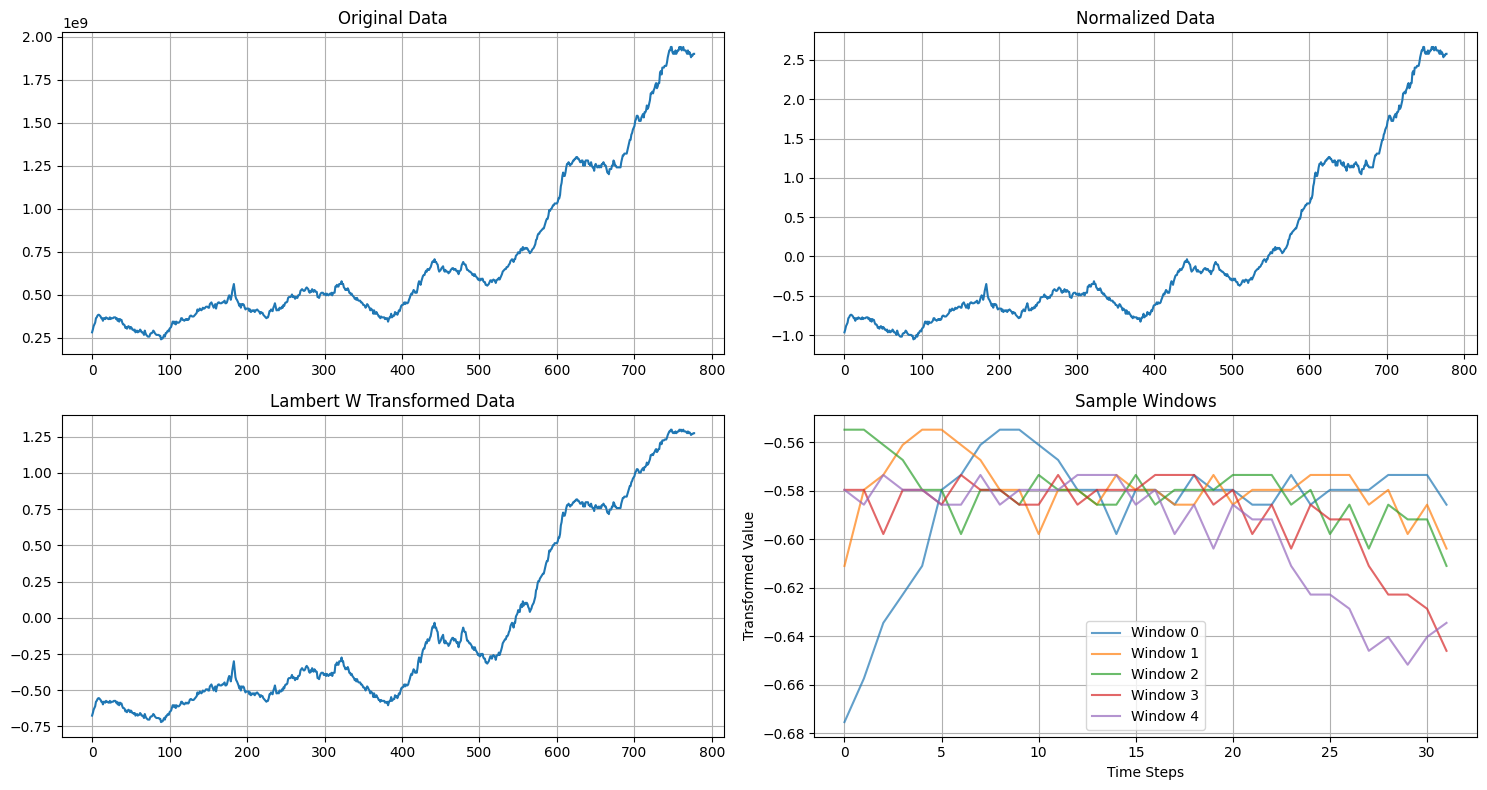

In [12]:
# Apply the preprocessing pipeline
# First normalize the data
normalized_data, mu, sigma = normalize(data)
print("\nAfter normalization:")
print(f"Mean: {np.mean(normalized_data):.4f}")
print(f"Std: {np.std(normalized_data):.4f}")

# Then apply Lambert W transformation
transformed_data = lambert_w_transform(normalized_data)
print("\nAfter Lambert W transformation:")
print(f"Mean: {np.mean(transformed_data):.4f}")
print(f"Std: {np.std(transformed_data):.4f}")

# Create sliding windows
window_size = 32  # Size of each window
stride = 4        # Number of time steps to move forward
dataset = TimeSeriesDataset(transformed_data, window_size, stride)

print(f"\nDataset creation:")
print(f"Number of windows created: {len(dataset)}")
print(f"Window shape: {dataset[0].shape}")

# Visualize the preprocessing steps
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Original data
axes[0,0].plot(data)
axes[0,0].set_title('Original Data')
axes[0,0].grid(True)

# Normalized data
axes[0,1].plot(normalized_data)
axes[0,1].set_title('Normalized Data')
axes[0,1].grid(True)

# Transformed data
axes[1,0].plot(transformed_data)
axes[1,0].set_title('Lambert W Transformed Data')
axes[1,0].grid(True)

# Sample windows
for i in range(5):
    axes[1,1].plot(dataset[i], label=f'Window {i}', alpha=0.7)
axes[1,1].set_title('Sample Windows')
axes[1,1].set_xlabel('Time Steps')
axes[1,1].set_ylabel('Transformed Value')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()




## Quantum Circuit Setup

Now we'll set up our quantum device and define the quantum circuit for the generator. We'll use PennyLane's quantum nodes to create our quantum circuit.


In [17]:
# Quantum circuit parameters
n_qubits = 5  # Total number of qubits
n_layers = 6  # Number of layers in the circuit

# Initialize the quantum device
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(params, noise):
    """
    Quantum circuit for the generator.
    
    Args:
        params (array): Circuit parameters
        noise (array): Classical noise input
    """
    # Encode the noise input
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)
    
    # Apply parameterized quantum layers
    param_idx = 0
    for layer in range(n_layers):
        # Rotation layer
        for i in range(n_qubits):
            qml.RX(params[param_idx], wires=i)
            param_idx += 1
            qml.RY(params[param_idx], wires=i)
            param_idx += 1
            qml.RZ(params[param_idx], wires=i)
            param_idx += 1
        
        # Entangling layer
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])
    
    # Measure all qubits
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Initialize random parameters
num_params = n_qubits * n_layers * 3  # 3 rotation gates per qubit per layer
params = np.random.uniform(low=-np.pi, high=np.pi, size=num_params)

# Test the circuit
test_noise = np.random.uniform(low=-np.pi, high=np.pi, size=n_qubits)
output = quantum_circuit(params, test_noise)
print("Quantum circuit output shape:", len(output))
print("Sample output:", output)

# Visualize the quantum circuit
print("\nQuantum Circuit Visualization:")
print(qml.draw(quantum_circuit)(params, test_noise))


Quantum circuit output shape: 5
Sample output: [tensor(0.02541453, requires_grad=True), tensor(-0.09068597, requires_grad=True), tensor(-0.04166136, requires_grad=True), tensor(-0.0214111, requires_grad=True), tensor(-0.0818288, requires_grad=True)]

Quantum Circuit Visualization:
0: ──RY(0.10)───RX(-2.44)──RY(-0.38)──RZ(-1.87)─╭●──────────╭X──RX(0.78)───RY(-1.28)──RZ(-2.48)─╭●
1: ──RY(-1.50)──RX(2.49)───RY(-0.15)──RZ(0.40)──╰X─╭●───────│───RX(-0.27)──RY(-1.77)──RZ(-0.52)─╰X
2: ──RY(3.12)───RX(1.23)───RY(-2.27)──RZ(0.66)─────╰X─╭●────│───RX(2.41)───RY(-1.10)──RZ(-2.37)───
3: ──RY(2.92)───RX(0.25)───RY(-1.87)──RZ(2.78)────────╰X─╭●─│───RX(-0.90)──RY(2.56)───RZ(-1.43)───
4: ──RY(0.37)───RX(0.62)───RY(1.22)───RZ(2.39)───────────╰X─╰●──RX(0.93)───RY(-3.14)──RZ(-0.93)───

───────────╭X──RX(-1.23)──RY(-2.11)──RZ(0.21)──╭●──────────╭X──RX(1.33)───RY(-2.21)──RZ(3.13)──╭●───
──╭●───────│───RX(-0.10)──RY(1.21)───RZ(-1.45)─╰X─╭●───────│───RX(-1.47)──RY(2.99)───RZ(-0.56)─╰X─╭●
──╰X─╭●────│───RX(-1

## Generator and Discriminator Models

Now we'll define our hybrid quantum-classical GAN architecture. The generator will use the quantum circuit we defined above, while the discriminator will be a classical neural network.


In [20]:
class QuantumGenerator(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        num_params = n_qubits * n_layers * 3
        
        # Trainable parameters for the quantum circuit
        self.params = nn.Parameter(torch.randn(num_params) * 0.1)
        
        # Linear layer to map quantum output to desired window size
        self.output_layer = nn.Sequential(
            nn.Linear(n_qubits, window_size),
            nn.Tanh()
        )
    
    def forward(self, noise):
        # Convert noise to numpy for quantum circuit
        noise_np = noise.detach().numpy()
        params_np = self.params.detach().numpy()
        
        # Run quantum circuit for each noise sample in the batch
        quantum_outputs = []
        for i in range(noise.shape[0]):
            # Get output for single noise sample
            output = quantum_circuit(params_np, noise_np[i])
            # Convert list of tensors to numpy array
            output_np = np.array([t.numpy() for t in output])
            quantum_outputs.append(output_np)
            
        # Stack all outputs into a single tensor
        quantum_out = torch.tensor(np.stack(quantum_outputs), dtype=torch.float32, requires_grad=True)
        
        # Map quantum output to window size
        return self.output_layer(quantum_out)

class Discriminator(nn.Module):
    def __init__(self, window_size):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(window_size, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize models
generator = QuantumGenerator(n_qubits, n_layers)
discriminator = Discriminator(window_size)

# Loss function
criterion = nn.BCELoss()

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Create data loader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

print("Generator parameters:", sum(p.numel() for p in generator.parameters()))
print("Discriminator parameters:", sum(p.numel() for p in discriminator.parameters()))


Generator parameters: 282
Discriminator parameters: 4737


## Training Loop

Now we'll implement the training loop for our quantum GAN. We'll use the Wasserstein loss with gradient penalty to improve training stability.


Epoch [10/100] D_loss: 0.6144 G_loss: -0.3498
Epoch [20/100] D_loss: 0.2384 G_loss: -0.3278
Epoch [30/100] D_loss: 0.2132 G_loss: -0.2902
Epoch [40/100] D_loss: 0.3502 G_loss: -0.2888
Epoch [50/100] D_loss: 1.0599 G_loss: -0.3097
Epoch [60/100] D_loss: 0.7371 G_loss: -0.3135
Epoch [70/100] D_loss: 0.3783 G_loss: -0.3245
Epoch [80/100] D_loss: 0.3046 G_loss: -0.3003
Epoch [90/100] D_loss: 0.4264 G_loss: -0.3112
Epoch [100/100] D_loss: 0.6675 G_loss: -0.3064


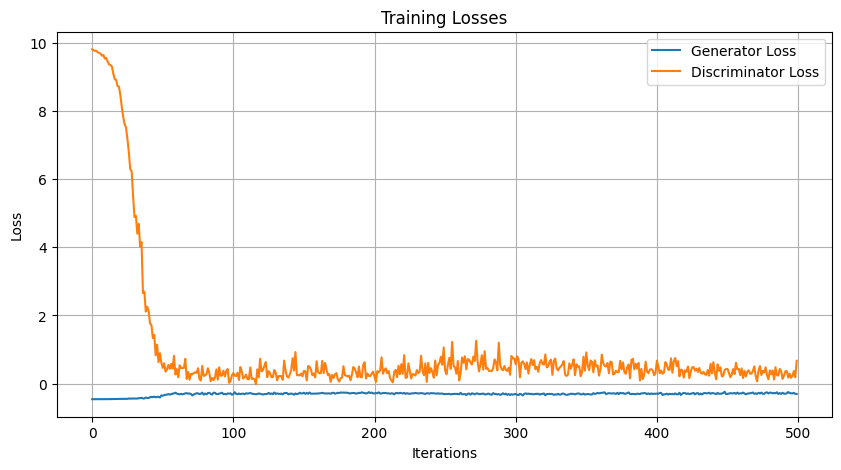

In [21]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """Calculate gradient penalty for WGAN-GP"""
    batch_size = real_samples.size(0)
    alpha = torch.rand(batch_size, 1)
    alpha = alpha.expand_as(real_samples)
    
    # Interpolated samples
    interpolated = alpha * real_samples + (1 - alpha) * fake_samples
    interpolated.requires_grad_(True)
    
    # Calculate probability of interpolated examples
    d_interpolated = discriminator(interpolated)
    
    # Calculate gradients of probabilities with respect to examples
    gradients = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(d_interpolated),
        create_graph=True,
        retain_graph=True
    )[0]
    
    # Calculate gradient penalty
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()
    
    return gradient_penalty

# Training parameters
n_epochs = 100
n_critic = 5  # Number of discriminator updates per generator update
lambda_gp = 10  # Gradient penalty coefficient

# Lists to store losses for plotting
g_losses = []
d_losses = []

# Training loop
for epoch in range(n_epochs):
    for i, real_samples in enumerate(dataloader):
        batch_size = real_samples.size(0)
        
        # Train Discriminator
        for _ in range(n_critic):
            d_optimizer.zero_grad()
            
            # Generate noise
            noise = torch.randn(batch_size, n_qubits)
            
            # Generate fake samples
            fake_samples = generator(noise)
            
            # Calculate Wasserstein loss
            d_real = discriminator(real_samples)
            d_fake = discriminator(fake_samples.detach())
            d_loss = -torch.mean(d_real) + torch.mean(d_fake)
            
            # Calculate gradient penalty
            gp = gradient_penalty(discriminator, real_samples, fake_samples.detach())
            
            # Add gradient penalty to discriminator loss
            d_loss = d_loss + lambda_gp * gp
            
            d_loss.backward()
            d_optimizer.step()
        
        # Train Generator
        g_optimizer.zero_grad()
        
        # Generate new fake samples
        noise = torch.randn(batch_size, n_qubits)
        fake_samples = generator(noise)
        
        # Calculate generator loss
        g_loss = -torch.mean(discriminator(fake_samples))
        
        g_loss.backward()
        g_optimizer.step()
        
        # Store losses
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}] "
              f"D_loss: {d_loss.item():.4f} "
              f"G_loss: {g_loss.item():.4f}")

# Plot training losses
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True)
plt.show()


## Generate and Evaluate Samples

Now that we have trained our quantum GAN, let's generate some samples and compare them with the original data to evaluate the quality of our generated time series.


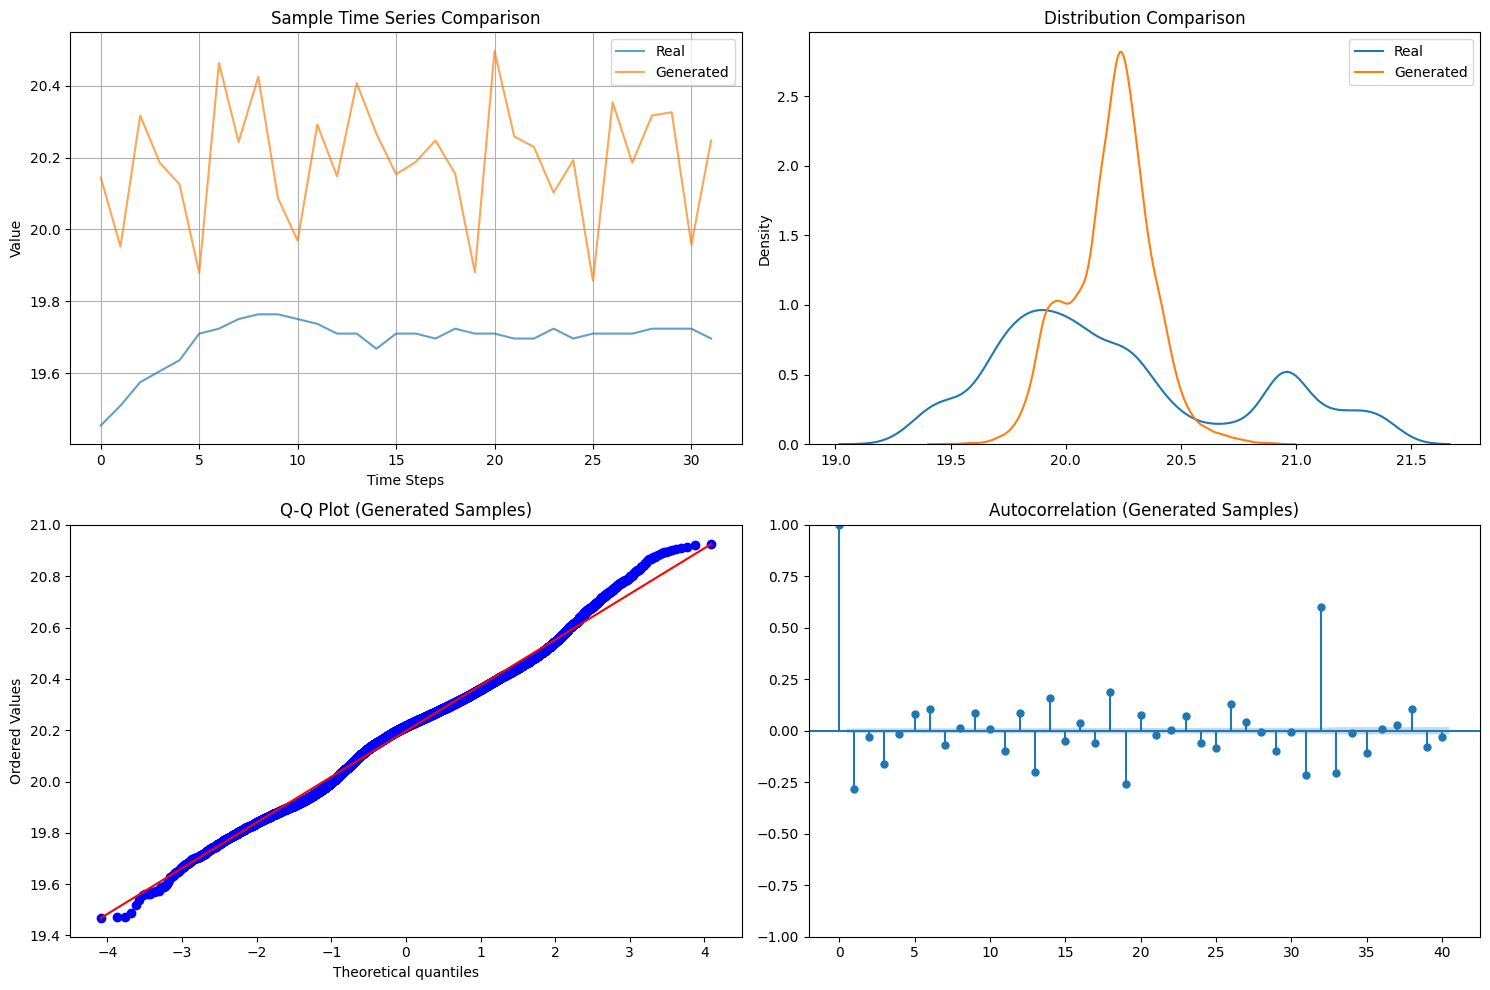


Statistical Comparison:
Real Data:
Mean: 20.2183
Std: 0.5314
Skewness: 0.6161
Kurtosis: -0.6361

Generated Data:
Mean: 20.1965
Std: 0.1790
Skewness: -0.1059
Kurtosis: 0.2527

Wasserstein Distance: 0.2994


In [24]:
# Generate samples
n_samples = 1000
noise = torch.randn(n_samples, n_qubits)
generated_samples = generator(noise).detach().numpy()

# Transform back to original scale
generated_samples = inverse_lambert_w_transform(generated_samples)
generated_samples = denormalize(generated_samples, mu, sigma)

# Prepare real samples for comparison
real_samples = dataset[:n_samples]  # dataset is already a numpy array
real_samples = inverse_lambert_w_transform(real_samples)
real_samples = denormalize(real_samples, mu, sigma)

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Time series plot
axes[0,0].plot(real_samples[0], label='Real', alpha=0.7)
axes[0,0].plot(generated_samples[0], label='Generated', alpha=0.7)
axes[0,0].set_title('Sample Time Series Comparison')
axes[0,0].set_xlabel('Time Steps')
axes[0,0].set_ylabel('Value')
axes[0,0].legend()
axes[0,0].grid(True)

# Distribution plot
sns.kdeplot(data=real_samples.flatten(), ax=axes[0,1], label='Real')
sns.kdeplot(data=generated_samples.flatten(), ax=axes[0,1], label='Generated')
axes[0,1].set_title('Distribution Comparison')
axes[0,1].legend()

# Q-Q plot
stats.probplot(generated_samples.flatten(), dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot (Generated Samples)')

# Autocorrelation plot
sm.graphics.tsa.plot_acf(generated_samples.flatten(), lags=40, ax=axes[1,1])
axes[1,1].set_title('Autocorrelation (Generated Samples)')

plt.tight_layout()
plt.show()

# Calculate statistical metrics
print("\nStatistical Comparison:")
print("Real Data:")
print(f"Mean: {np.mean(real_samples):.4f}")
print(f"Std: {np.std(real_samples):.4f}")
print(f"Skewness: {stats.skew(real_samples.flatten()):.4f}")
print(f"Kurtosis: {stats.kurtosis(real_samples.flatten()):.4f}")

print("\nGenerated Data:")
print(f"Mean: {np.mean(generated_samples):.4f}")
print(f"Std: {np.std(generated_samples):.4f}")
print(f"Skewness: {stats.skew(generated_samples.flatten()):.4f}")
print(f"Kurtosis: {stats.kurtosis(generated_samples.flatten()):.4f}")

# Calculate Wasserstein distance
wd = wasserstein_distance(real_samples.flatten(), generated_samples.flatten())
print(f"\nWasserstein Distance: {wd:.4f}")

# Save generated samples
generated_df = pd.DataFrame(generated_samples)
generated_df.to_csv('generated_samples.csv', index=False)


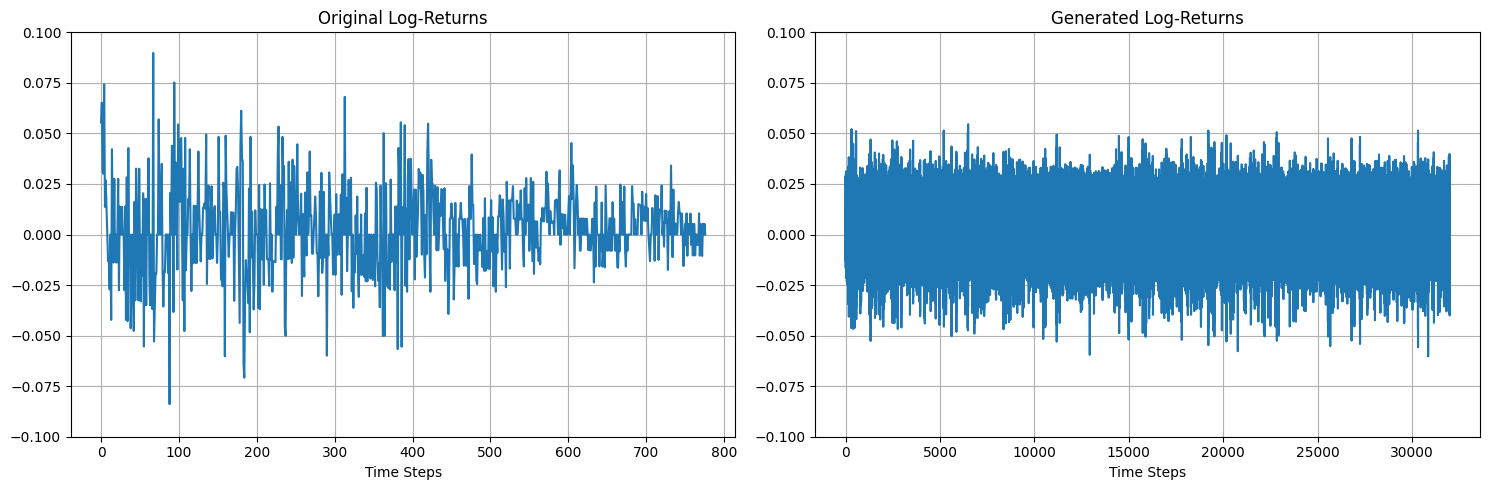


Log Returns Statistics Comparison:

Original Log Returns:
Mean: 0.0025
Std: 0.0211
Min: -0.0839
Max: 0.0898

Generated Log Returns:
Mean: 0.0000
Std: 0.0142
Min: -0.0602
Max: 0.0546


In [25]:
# Calculate log returns for both original and generated data
# For original data, we already have lucy_log_returns from earlier
original_log_returns = lucy_log_returns.numpy()

# For generated data, calculate log returns
generated_log_returns = np.diff(np.log(generated_samples.flatten()))

# Create time indices
original_time = np.arange(len(original_log_returns))
generated_time = np.arange(len(generated_log_returns))

# Create the comparison plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Plot original log-returns
axes[0].plot(original_time, original_log_returns)
axes[0].set_xlabel('Time Steps')
axes[0].set_title('Original Log-Returns')
axes[0].grid(True)
axes[0].set_ylim([-0.1, 0.1])

# Plot generated log-returns
axes[1].plot(generated_time, generated_log_returns)
axes[1].set_xlabel('Time Steps')
axes[1].set_title('Generated Log-Returns')
axes[1].grid(True)
axes[1].set_ylim([-0.1, 0.1])

plt.tight_layout()
plt.show()

# Print some statistics about the log returns
print("\nLog Returns Statistics Comparison:")
print("\nOriginal Log Returns:")
print(f"Mean: {np.mean(original_log_returns):.4f}")
print(f"Std: {np.std(original_log_returns):.4f}")
print(f"Min: {np.min(original_log_returns):.4f}")
print(f"Max: {np.max(original_log_returns):.4f}")

print("\nGenerated Log Returns:")
print(f"Mean: {np.mean(generated_log_returns):.4f}")
print(f"Std: {np.std(generated_log_returns):.4f}")
print(f"Min: {np.min(generated_log_returns):.4f}")
print(f"Max: {np.max(generated_log_returns):.4f}")


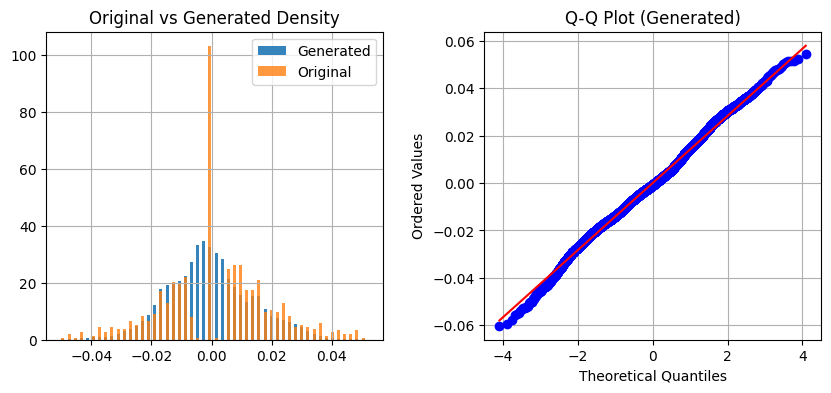


Distribution Comparison Statistics:

Kolmogorov-Smirnov test:
KS statistic: 0.1910
p-value: 0.0000

Anderson-Darling test for normality:
Generated data:
AD statistic: 63.4695
Original data:
AD statistic: 4.7087


In [26]:
# Create comparison plots of distributions
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

# Define bin edges for histogram
bin_edges = np.linspace(-0.05, 0.05, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)

# Plot histograms of original and generated log returns
axes[0].hist(generated_log_returns, bins=bin_edges, density=True, width=0.001, 
             label='Generated', alpha=0.9)
axes[0].hist(original_log_returns, bins=bin_edges, density=True, width=0.001, 
             label='Original', alpha=0.8)
axes[0].set_title('Original vs Generated Density')
axes[0].grid(True)
axes[0].legend()

# Create Q-Q plot for generated data
stats.probplot(generated_log_returns, dist='norm', plot=axes[1])
axes[1].set_title('Q-Q Plot (Generated)')
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].grid(True)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)
plt.show()

# Print additional distribution comparison statistics
print("\nDistribution Comparison Statistics:")
print("\nKolmogorov-Smirnov test:")
ks_stat, ks_pval = stats.ks_2samp(original_log_returns, generated_log_returns)
print(f"KS statistic: {ks_stat:.4f}")
print(f"p-value: {ks_pval:.4f}")

print("\nAnderson-Darling test for normality:")
print("Generated data:")
ad_stat, ad_crit, ad_sig = stats.anderson(generated_log_returns, dist='norm')
print(f"AD statistic: {ad_stat:.4f}")
print("Original data:")
ad_stat_orig, ad_crit_orig, ad_sig_orig = stats.anderson(original_log_returns, dist='norm')
print(f"AD statistic: {ad_stat_orig:.4f}")


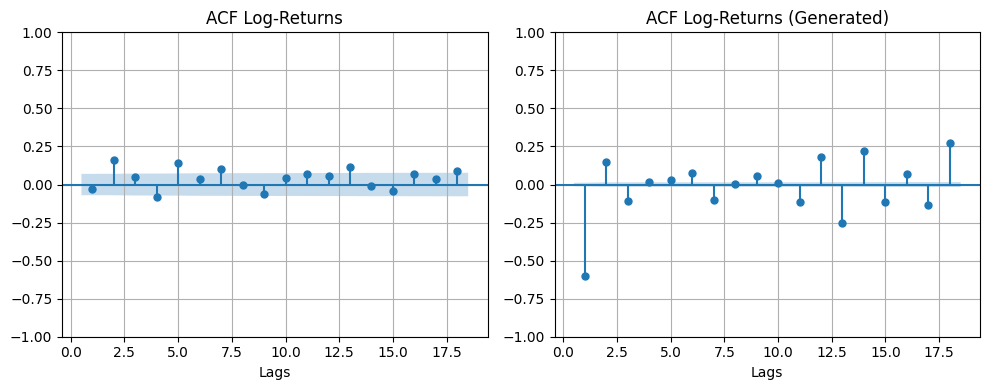


Autocorrelation Statistics:

Original Log Returns:
First 5 autocorrelation values:
Lag 1: -0.0300
Lag 2: 0.1619
Lag 3: 0.0500
Lag 4: -0.0807
Lag 5: 0.1431

Generated Log Returns:
First 5 autocorrelation values:
Lag 1: -0.5993
Lag 2: 0.1506
Lag 3: -0.1080
Lag 4: 0.0188
Lag 5: 0.0286

Ljung-Box Test (tests for presence of autocorrelation):
Original - Statistic: 57.8765, p-value: 0.0000
Generated - Statistic: 13241.1696, p-value: 0.0000


In [29]:
# Create comparison plots of autocorrelations
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

# Plot ACF of original log returns
tsaplots.plot_acf(original_log_returns, ax=axes[0], lags=18, zero=False)
axes[0].set_xlabel('Lags')
axes[0].set_title('ACF Log-Returns')
axes[0].grid(True)

# Plot ACF of generated log returns
tsaplots.plot_acf(generated_log_returns, ax=axes[1], lags=18, zero=False)
axes[1].set_xlabel('Lags')
axes[1].set_title('ACF Log-Returns (Generated)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print some additional autocorrelation statistics
print("\nAutocorrelation Statistics:")
print("\nOriginal Log Returns:")
acf_orig = sm.tsa.acf(original_log_returns, nlags=5)
print("First 5 autocorrelation values:")
for i, acf in enumerate(acf_orig[1:], 1):  # Skip lag 0
    print(f"Lag {i}: {acf:.4f}")

print("\nGenerated Log Returns:")
acf_gen = sm.tsa.acf(generated_log_returns, nlags=5)
print("First 5 autocorrelation values:")
for i, acf in enumerate(acf_gen[1:], 1):  # Skip lag 0
    print(f"Lag {i}: {acf:.4f}")

# Calculate Ljung-Box test for both series
print("\nLjung-Box Test (tests for presence of autocorrelation):")
lb_orig = sm.stats.acorr_ljungbox(original_log_returns, lags=10)  # Returns a DataFrame
lb_gen = sm.stats.acorr_ljungbox(generated_log_returns, lags=10)  # Returns a DataFrame

print(f"Original - Statistic: {lb_orig['lb_stat'].iloc[-1]:.4f}, p-value: {lb_orig['lb_pvalue'].iloc[-1]:.4f}")
print(f"Generated - Statistic: {lb_gen['lb_stat'].iloc[-1]:.4f}, p-value: {lb_gen['lb_pvalue'].iloc[-1]:.4f}")


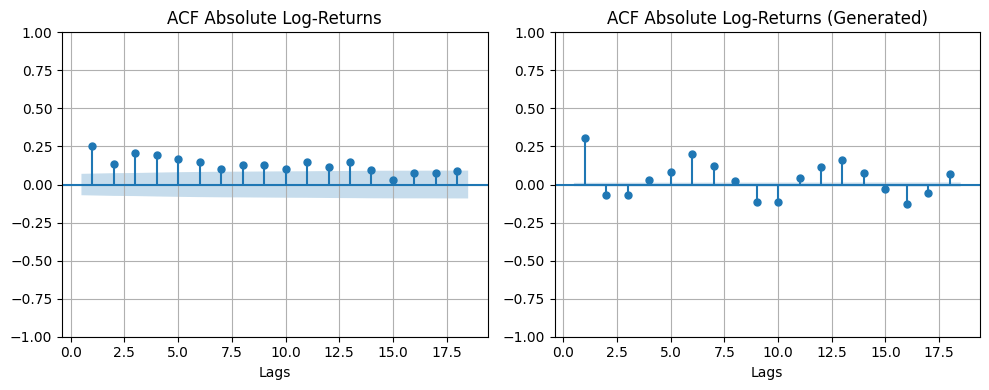


Absolute Log Returns Statistics:

Original Absolute Log Returns:
First 5 autocorrelation values:
Lag 1: 0.2500
Lag 2: 0.1368
Lag 3: 0.2082
Lag 4: 0.1963
Lag 5: 0.1701

Generated Absolute Log Returns:
First 5 autocorrelation values:
Lag 1: 0.3086
Lag 2: -0.0662
Lag 3: -0.0667
Lag 4: 0.0306
Lag 5: 0.0848

Ljung-Box Test for Absolute Returns:
Original Absolute - Statistic: 211.6874, p-value: 0.0000
Generated Absolute - Statistic: 6173.9674, p-value: 0.0000


In [30]:
# Create comparison plots of absolute log returns autocorrelations
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

# Plot ACF of absolute original log returns
tsaplots.plot_acf(np.abs(original_log_returns), ax=axes[0], lags=18, zero=False)
axes[0].set_xlabel('Lags')
axes[0].set_title('ACF Absolute Log-Returns')
axes[0].grid(True)

# Plot ACF of absolute generated log returns
tsaplots.plot_acf(np.abs(generated_log_returns), ax=axes[1], lags=18, zero=False)
axes[1].set_xlabel('Lags')
axes[1].set_title('ACF Absolute Log-Returns (Generated)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print some additional statistics for absolute returns
print("\nAbsolute Log Returns Statistics:")
print("\nOriginal Absolute Log Returns:")
acf_abs_orig = sm.tsa.acf(np.abs(original_log_returns), nlags=5)
print("First 5 autocorrelation values:")
for i, acf in enumerate(acf_abs_orig[1:], 1):  # Skip lag 0
    print(f"Lag {i}: {acf:.4f}")

print("\nGenerated Absolute Log Returns:")
acf_abs_gen = sm.tsa.acf(np.abs(generated_log_returns), nlags=5)
print("First 5 autocorrelation values:")
for i, acf in enumerate(acf_abs_gen[1:], 1):  # Skip lag 0
    print(f"Lag {i}: {acf:.4f}")

# Calculate Ljung-Box test for absolute returns
print("\nLjung-Box Test for Absolute Returns:")
lb_abs_orig = sm.stats.acorr_ljungbox(np.abs(original_log_returns), lags=10)
lb_abs_gen = sm.stats.acorr_ljungbox(np.abs(generated_log_returns), lags=10)

print(f"Original Absolute - Statistic: {lb_abs_orig['lb_stat'].iloc[-1]:.4f}, p-value: {lb_abs_orig['lb_pvalue'].iloc[-1]:.4f}")
print(f"Generated Absolute - Statistic: {lb_abs_gen['lb_stat'].iloc[-1]:.4f}, p-value: {lb_abs_gen['lb_pvalue'].iloc[-1]:.4f}")


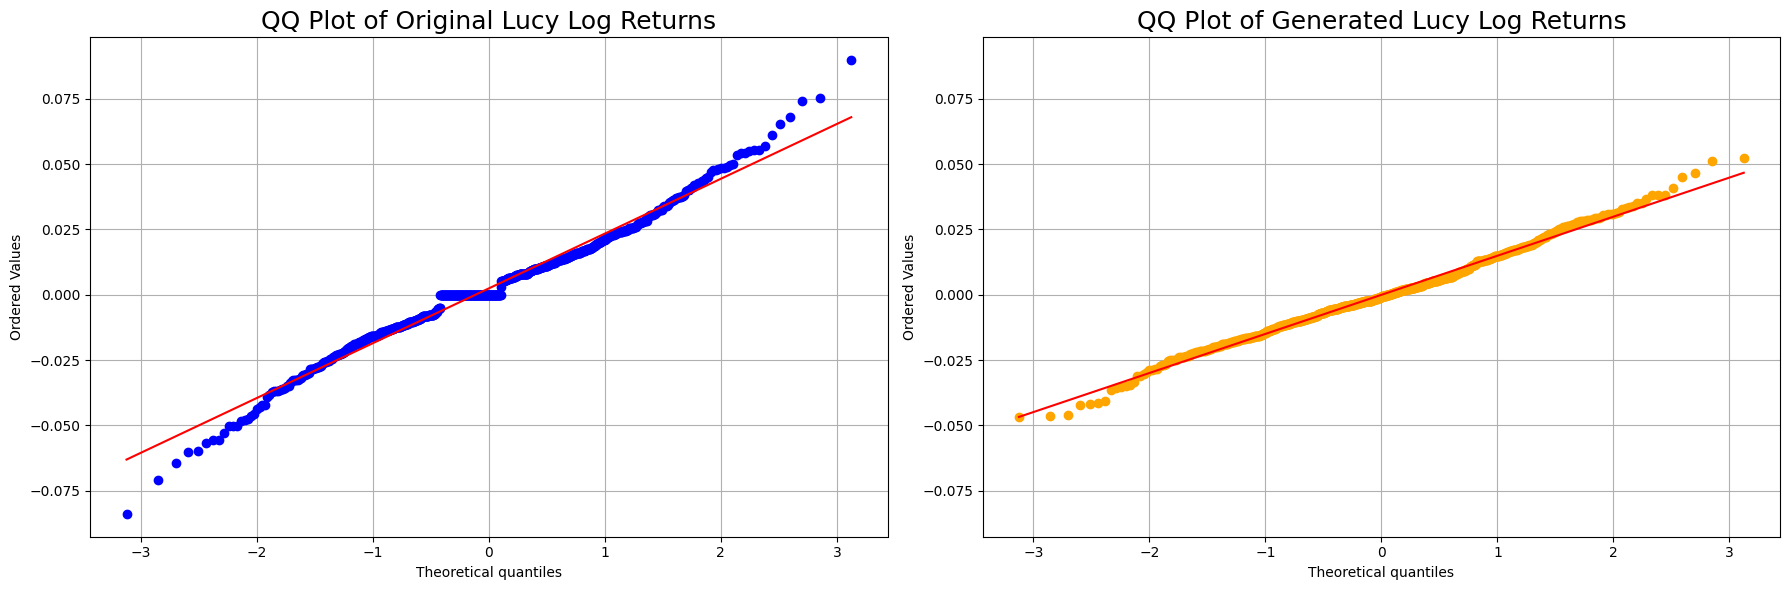


Normality Tests:

Original Log Returns:
Shapiro-Wilk test p-value: 0.0000
Kolmogorov-Smirnov test p-value: 0.0000

Generated Log Returns:
Shapiro-Wilk test p-value: 0.0009
Kolmogorov-Smirnov test p-value: 0.0000

Skewness and Kurtosis:

Original Log Returns:
Skewness: 0.0066
Kurtosis: 1.3363

Generated Log Returns:
Skewness: 0.1706
Kurtosis: 0.5007


In [31]:
# Ensure both time series are of the same length for comparison
min_length = min(len(original_log_returns), len(generated_log_returns))
real_ts = original_log_returns[:min_length]
fake_ts = generated_log_returns[:min_length]

# Generate QQ plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# QQ plot for the original Lucy log returns
stats.probplot(real_ts, dist="norm", plot=ax1)
ax1.set_title('QQ Plot of Original Lucy Log Returns', fontsize=18)
ax1.grid(True)

# QQ plot for the generated Lucy log returns
stats.probplot(fake_ts, dist="norm", plot=ax2)
ax2.get_lines()[0].set_color('orange')
ax2.set_title('QQ Plot of Generated Lucy Log Returns', fontsize=18)
ax2.grid(True)

# Set the same scale for y axis
ylim1 = ax1.get_ylim()
ylim2 = ax2.get_ylim()
global_ylim = (min(ylim1[0], ylim2[0]), max(ylim1[1], ylim2[1]))
ax1.set_ylim(global_ylim)
ax2.set_ylim(global_ylim)

# Show the plots
plt.tight_layout()
plt.show()

# Print additional normality test statistics
print("\nNormality Tests:")
print("\nOriginal Log Returns:")
_, shapiro_p_orig = stats.shapiro(real_ts)
print(f"Shapiro-Wilk test p-value: {shapiro_p_orig:.4f}")
_, ks_p_orig = stats.kstest(real_ts, 'norm')
print(f"Kolmogorov-Smirnov test p-value: {ks_p_orig:.4f}")

print("\nGenerated Log Returns:")
_, shapiro_p_gen = stats.shapiro(fake_ts)
print(f"Shapiro-Wilk test p-value: {shapiro_p_gen:.4f}")
_, ks_p_gen = stats.kstest(fake_ts, 'norm')
print(f"Kolmogorov-Smirnov test p-value: {ks_p_gen:.4f}")

# Calculate and print skewness and kurtosis
print("\nSkewness and Kurtosis:")
print("\nOriginal Log Returns:")
print(f"Skewness: {stats.skew(real_ts):.4f}")
print(f"Kurtosis: {stats.kurtosis(real_ts):.4f}")

print("\nGenerated Log Returns:")
print(f"Skewness: {stats.skew(fake_ts):.4f}")
print(f"Kurtosis: {stats.kurtosis(fake_ts):.4f}")


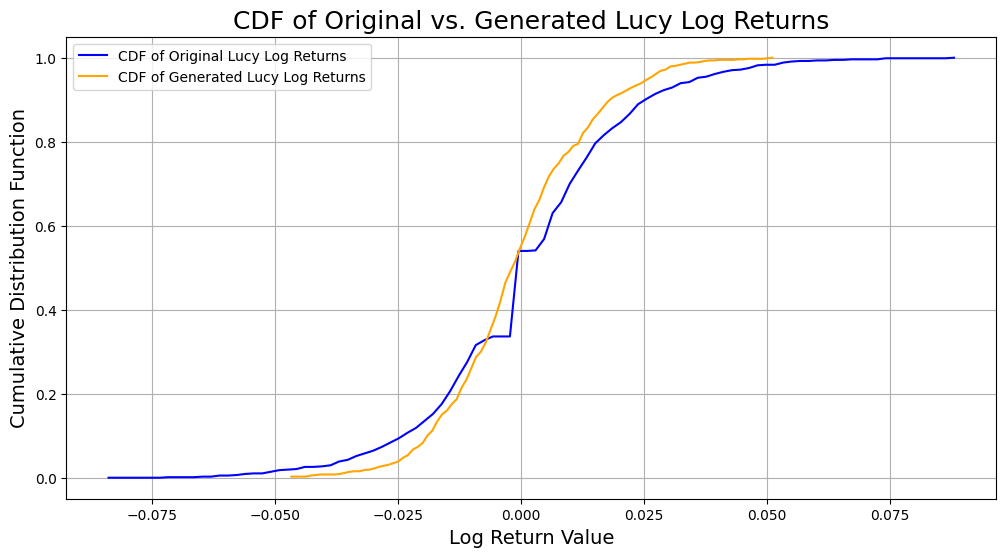

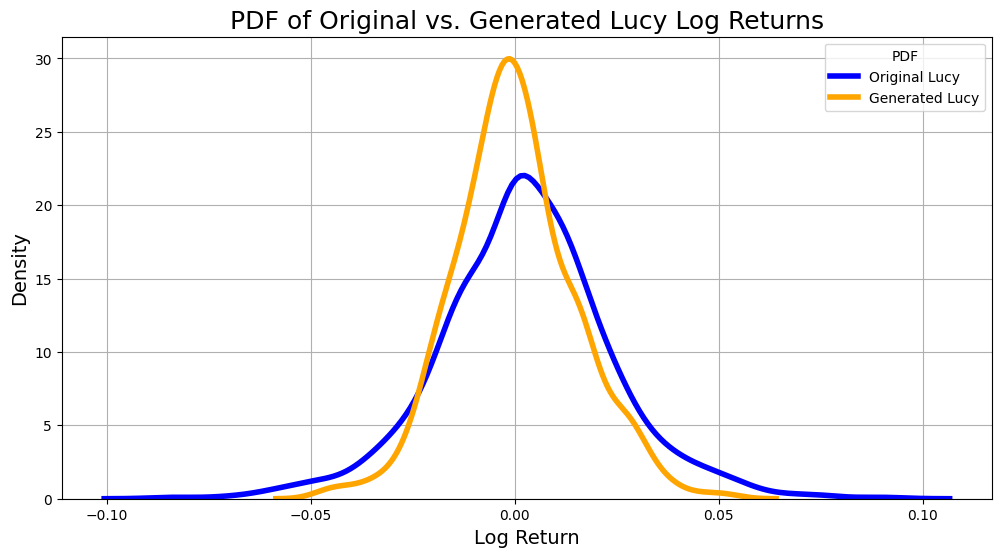


Distribution Comparison Metrics:
KL Divergence: inf
Wasserstein Distance: 0.0052

Distribution Statistics:

Original Log Returns:
Mean: 0.0025
Std Dev: 0.0211
25th Percentile: -0.0104
Median: 0.0000
75th Percentile: 0.0141

Generated Log Returns:
Mean: -0.0000
Std Dev: 0.0150
25th Percentile: -0.0096
Median: -0.0008
75th Percentile: 0.0087


In [32]:
# Calculate the probability distribution of the real and fake time series
real_ts_values, real_ts_base = np.histogram(real_ts, bins=100, density=True)
fake_ts_values, fake_ts_base = np.histogram(fake_ts, bins=100, density=True)

# Compute the cumulative distribution functions for both time series
real_ts_cdf = np.cumsum(real_ts_values * np.diff(real_ts_base))
fake_ts_cdf = np.cumsum(fake_ts_values * np.diff(fake_ts_base))

# Plotting the CDFs
plt.figure(figsize=(12, 6))
plt.plot(real_ts_base[:-1], real_ts_cdf, label='CDF of Original Lucy Log Returns', color='blue')
plt.plot(fake_ts_base[:-1], fake_ts_cdf, label='CDF of Generated Lucy Log Returns', color='orange')
plt.xlabel('Log Return Value', fontsize=14)
plt.ylabel('Cumulative Distribution Function', fontsize=14)
plt.title('CDF of Original vs. Generated Lucy Log Returns', fontsize=18)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plotting the PDFs using seaborn's kdeplot
plt.figure(figsize=(12, 6))

# Plot PDF of original log returns
sns.kdeplot(data=real_ts, color='blue', linewidth=4, label='Original Lucy')
# Plot PDF of generated log returns
sns.kdeplot(data=fake_ts, color='orange', linewidth=4, label='Generated Lucy')

# Plot formatting
plt.legend(prop={'size': 10}, title='PDF')
plt.title('PDF of Original vs. Generated Lucy Log Returns', fontsize=18)
plt.xlabel('Log Return', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(True)

plt.show()

# Calculate KL divergence and other distribution metrics
from scipy.stats import entropy

# Calculate KL divergence using the histogram values
kl_div = entropy(real_ts_values, fake_ts_values)

# Calculate Wasserstein distance (Earth Mover's Distance)
w_distance = stats.wasserstein_distance(real_ts, fake_ts)

print("\nDistribution Comparison Metrics:")
print(f"KL Divergence: {kl_div:.4f}")
print(f"Wasserstein Distance: {w_distance:.4f}")

# Calculate distribution statistics
print("\nDistribution Statistics:")
print("\nOriginal Log Returns:")
print(f"Mean: {np.mean(real_ts):.4f}")
print(f"Std Dev: {np.std(real_ts):.4f}")
print(f"25th Percentile: {np.percentile(real_ts, 25):.4f}")
print(f"Median: {np.median(real_ts):.4f}")
print(f"75th Percentile: {np.percentile(real_ts, 75):.4f}")

print("\nGenerated Log Returns:")
print(f"Mean: {np.mean(fake_ts):.4f}")
print(f"Std Dev: {np.std(fake_ts):.4f}")
print(f"25th Percentile: {np.percentile(fake_ts, 25):.4f}")
print(f"Median: {np.median(fake_ts):.4f}")
print(f"75th Percentile: {np.percentile(fake_ts, 75):.4f}")


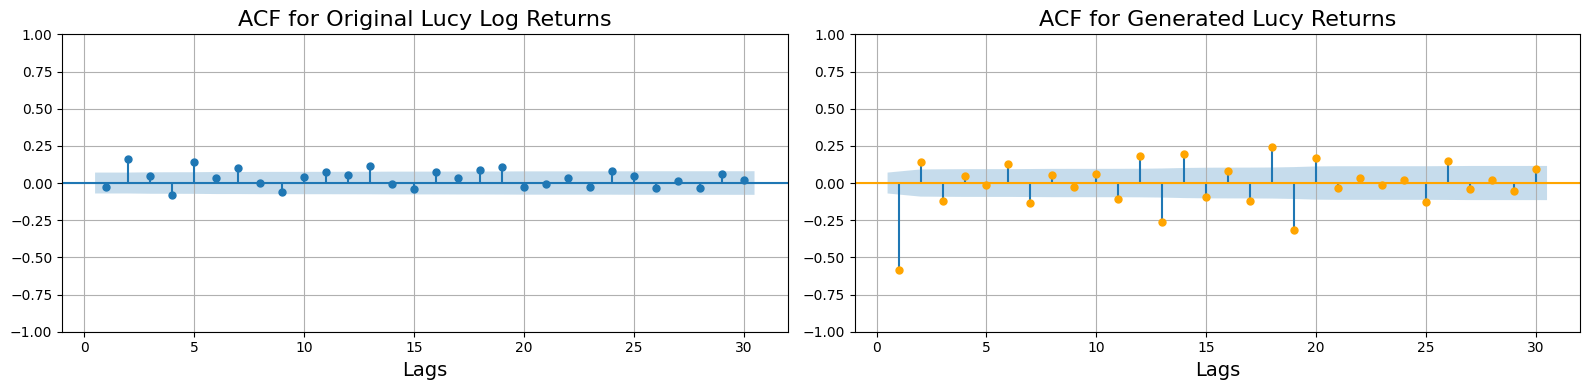


Autocorrelation Statistics:

Significant Lags (95% confidence):

Original Log Returns:
Lag 2: 0.1619
Lag 4: -0.0807
Lag 5: 0.1431
Lag 7: 0.1019
Lag 11: 0.0708
Lag 13: 0.1127
Lag 16: 0.0715
Lag 18: 0.0861
Lag 19: 0.1078
Lag 24: 0.0785

Generated Log Returns:
Lag 1: -0.5877
Lag 2: 0.1410
Lag 3: -0.1224
Lag 6: 0.1261
Lag 7: -0.1347
Lag 11: -0.1062
Lag 12: 0.1845
Lag 13: -0.2595
Lag 14: 0.1948
Lag 15: -0.0944
Lag 16: 0.0812
Lag 17: -0.1193
Lag 18: 0.2443
Lag 19: -0.3146
Lag 20: 0.1678
Lag 25: -0.1281
Lag 26: 0.1457
Lag 30: 0.0939

Ljung-Box Test (H0: no autocorrelation):

Original Log Returns:
Lag 10: stat=57.8765, p-value=0.0000
Lag 20: stat=96.6468, p-value=0.0000
Lag 30: stat=110.0171, p-value=0.0000

Generated Log Returns:
Lag 10: stat=330.8775, p-value=0.0000
Lag 20: stat=623.0105, p-value=0.0000
Lag 30: stat=666.5900, p-value=0.0000


In [33]:
# Creating the ACF plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

# Plot autocorrelations of original log-returns on the left
tsaplots.plot_acf(real_ts, ax=axes[0], lags=30, zero=False)
axes[0].set_xlabel('Lags', fontsize=14)
axes[0].set_title('ACF for Original Lucy Log Returns', fontsize=16)
axes[0].grid(True)

# Plot autocorrelations of generated log-returns on the right
tsaplots.plot_acf(fake_ts, ax=axes[1], lags=30, zero=False, color='orange')
axes[1].set_xlabel('Lags', fontsize=14)
axes[1].set_title('ACF for Generated Lucy Returns', fontsize=16)
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Calculate and print ACF statistics
print("\nAutocorrelation Statistics:")

# Calculate ACF values for both series
acf_orig = sm.tsa.acf(real_ts, nlags=30)
acf_gen = sm.tsa.acf(fake_ts, nlags=30)

# Print significant lags (using 95% confidence interval)
confidence_interval = 1.96/np.sqrt(len(real_ts))  # 95% CI

print("\nSignificant Lags (95% confidence):")
print("\nOriginal Log Returns:")
for i, acf in enumerate(acf_orig[1:], 1):  # Skip lag 0
    if abs(acf) > confidence_interval:
        print(f"Lag {i}: {acf:.4f}")

print("\nGenerated Log Returns:")
for i, acf in enumerate(acf_gen[1:], 1):  # Skip lag 0
    if abs(acf) > confidence_interval:
        print(f"Lag {i}: {acf:.4f}")

# Calculate Ljung-Box test for both series
print("\nLjung-Box Test (H0: no autocorrelation):")
lb_orig = sm.stats.acorr_ljungbox(real_ts, lags=[10, 20, 30])
lb_gen = sm.stats.acorr_ljungbox(fake_ts, lags=[10, 20, 30])

print("\nOriginal Log Returns:")
for i, (stat, pval) in enumerate(zip(lb_orig['lb_stat'], lb_orig['lb_pvalue']), 1):
    print(f"Lag {i*10}: stat={stat:.4f}, p-value={pval:.4f}")

print("\nGenerated Log Returns:")
for i, (stat, pval) in enumerate(zip(lb_gen['lb_stat'], lb_gen['lb_pvalue']), 1):
    print(f"Lag {i*10}: stat={stat:.4f}, p-value={pval:.4f}")


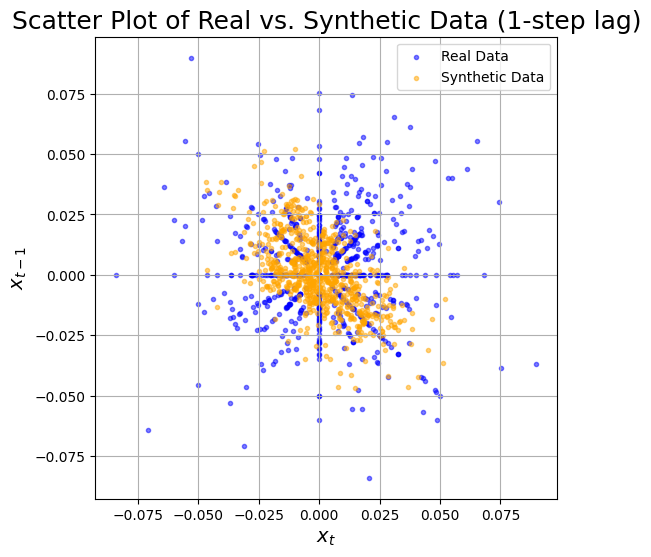


Lag Relationship Statistics:

Correlation between current and lagged values:
Real Data: -0.0301
Synthetic Data: -0.5900

Conditional Statistics:

Real Data:
Mean of x_t given x_t-1 > 0: 0.0025
Mean of x_t given x_t-1 < 0: 0.0027

Synthetic Data:
Mean of x_t given x_t-1 > 0: -0.0070
Mean of x_t given x_t-1 < 0: 0.0063

Quadrant Distribution (%):

Real Data:
Q1 (++): 22.0%
Q2 (-+): 15.3%
Q3 (--): 11.6%
Q4 (+-): 14.8%

Synthetic Data:
Q1 (++): 14.3%
Q2 (-+): 33.2%
Q3 (--): 19.2%
Q4 (+-): 33.2%


In [34]:
# Create lagged versions of the time series
def create_lagged_array(data):
    return data[:-1], data[1:]  # returns (lagged, current)

# Create lagged and current versions
real_ts_lagged, real_ts_current = create_lagged_array(real_ts)
fake_ts_lagged, fake_ts_current = create_lagged_array(fake_ts)

# Take the same number of points from each to have a fair comparison
min_length = min(len(real_ts_lagged), len(fake_ts_lagged))
real_ts_lagged = real_ts_lagged[:min_length]
real_ts_current = real_ts_current[:min_length]
fake_ts_lagged = fake_ts_lagged[:min_length]
fake_ts_current = fake_ts_current[:min_length]

# Create scatter plot
plt.figure(figsize=(14, 6))

# Plot real and synthetic data
plt.scatter(real_ts_current, real_ts_lagged, 
           color='blue', alpha=0.5, label='Real Data', marker='.')
plt.scatter(fake_ts_current, fake_ts_lagged, 
           color='orange', alpha=0.5, label='Synthetic Data', marker='.')

# Add labels and title
plt.xlabel('$x_t$', fontsize=14)
plt.ylabel('$x_{t-1}$', fontsize=14)
plt.title('Scatter Plot of Real vs. Synthetic Data (1-step lag)', fontsize=18)
plt.legend()
plt.grid(True)

# Make the plot square to better show the relationship
plt.axis('square')

plt.show()

# Calculate some statistics about the lag relationships
print("\nLag Relationship Statistics:")

# Calculate correlations
real_corr = np.corrcoef(real_ts_current, real_ts_lagged)[0,1]
fake_corr = np.corrcoef(fake_ts_current, fake_ts_lagged)[0,1]

print("\nCorrelation between current and lagged values:")
print(f"Real Data: {real_corr:.4f}")
print(f"Synthetic Data: {fake_corr:.4f}")

# Calculate conditional statistics
print("\nConditional Statistics:")
print("\nReal Data:")
print(f"Mean of x_t given x_t-1 > 0: {np.mean(real_ts_current[real_ts_lagged > 0]):.4f}")
print(f"Mean of x_t given x_t-1 < 0: {np.mean(real_ts_current[real_ts_lagged < 0]):.4f}")

print("\nSynthetic Data:")
print(f"Mean of x_t given x_t-1 > 0: {np.mean(fake_ts_current[fake_ts_lagged > 0]):.4f}")
print(f"Mean of x_t given x_t-1 < 0: {np.mean(fake_ts_current[fake_ts_lagged < 0]):.4f}")

# Calculate quadrant percentages
def calculate_quadrant_percentages(current, lagged):
    total = len(current)
    q1 = np.sum((current > 0) & (lagged > 0)) / total * 100
    q2 = np.sum((current < 0) & (lagged > 0)) / total * 100
    q3 = np.sum((current < 0) & (lagged < 0)) / total * 100
    q4 = np.sum((current > 0) & (lagged < 0)) / total * 100
    return q1, q2, q3, q4

real_quads = calculate_quadrant_percentages(real_ts_current, real_ts_lagged)
fake_quads = calculate_quadrant_percentages(fake_ts_current, fake_ts_lagged)

print("\nQuadrant Distribution (%):")
print("\nReal Data:")
print(f"Q1 (++): {real_quads[0]:.1f}%")
print(f"Q2 (-+): {real_quads[1]:.1f}%")
print(f"Q3 (--): {real_quads[2]:.1f}%")
print(f"Q4 (+-): {real_quads[3]:.1f}%")

print("\nSynthetic Data:")
print(f"Q1 (++): {fake_quads[0]:.1f}%")
print(f"Q2 (-+): {fake_quads[1]:.1f}%")
print(f"Q3 (--): {fake_quads[2]:.1f}%")
print(f"Q4 (+-): {fake_quads[3]:.1f}%")


In [36]:
!pip install fastdtw dtaidistance

  Using cached fastdtw-0.3.4-py3-none-any.whl
  Using cached dtaidistance-2.3.13-cp311-cp311-macosx_10_9_universal2.whl.metadata (13 kB)
Using cached dtaidistance-2.3.13-cp311-cp311-macosx_10_9_universal2.whl (1.5 MB)

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


DTW Distance between real and generated series: 13.3698


<Figure size 1200x800 with 0 Axes>

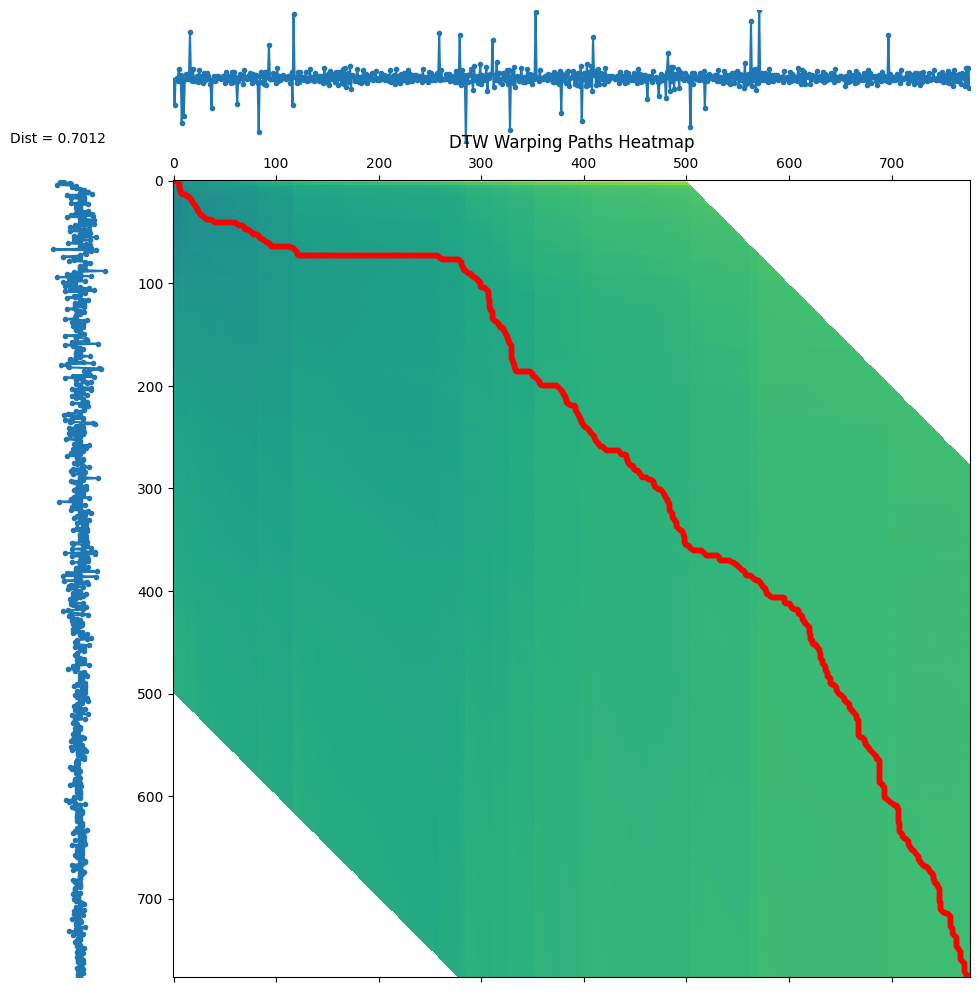

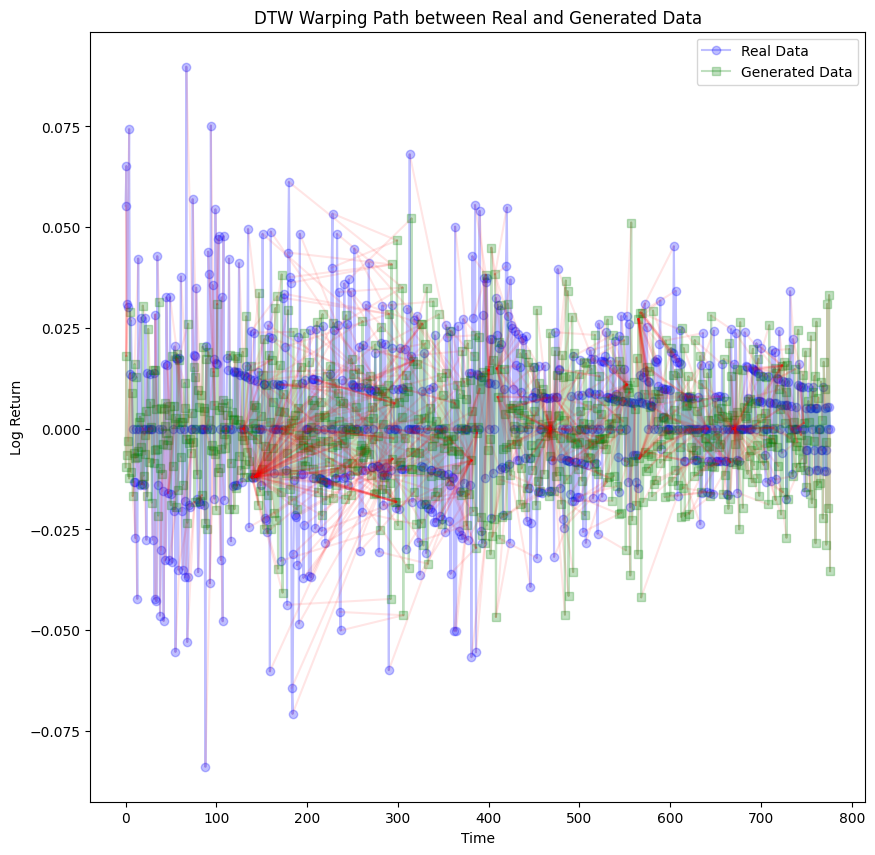


DTW Analysis Statistics:
DTW distance (window=10): 0.4335
DTW distance (window=50): 0.4017
DTW distance (window=100): 0.4017
DTW distance (window=500): 0.4013

Warping path statistics:
Average path length: 778.00
Max path length: 778.00
Min path length: 778.00

Alignment statistics:
Average time shift: 34.14
Max time shift: 116.00
Min time shift: 0.00


In [37]:
# Import required libraries for DTW analysis
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from dtaidistance import dtw_visualisation as dtwvis
from dtaidistance import dtw
import random

# Prepare the series for DTW analysis
series1 = real_ts.reshape(-1, 1)
series2 = fake_ts.reshape(-1, 1)

# Calculate DTW distance and warping path
dtw_distance, warping_path = fastdtw(series1, series2, dist=euclidean)

print(f"DTW Distance between real and generated series: {dtw_distance:.4f}")

# Add some random noise to series2 for better visualization (as in your example)
series2_noisy = series2.copy()
for idx in range(len(series2_noisy)):
    if random.random() < 0.05:
        series2_noisy[idx] += (random.random() - 0.5) / 2

# Calculate warping paths using dtaidistance
d, paths = dtw.warping_paths(series1.flatten(), series2_noisy.flatten(), window=500, psi=2)
best_path = dtw.best_path(paths)

# Plot warping paths using dtaidistance
plt.figure(figsize=(12, 8))
dtwvis.plot_warpingpaths(series1.flatten(), series2_noisy.flatten(), paths, best_path)
plt.title('DTW Warping Paths Heatmap')
plt.show()

# Create the warping path visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the first series on the x-axis
ax.plot(series1, 'bo-', label='Real Data', alpha=0.25)

# Plot the second series on the y-axis
ax.plot(series2, 'gs-', label='Generated Data', alpha=0.25)

# Draw lines between the matched points in the warping path
for (i, j) in warping_path:
    ax.plot([i, j], [series1[i], series2[j]], 'r-', alpha=0.1)

# Labeling the plot
ax.set_xlabel('Time')
ax.set_ylabel('Log Return')
ax.set_title('DTW Warping Path between Real and Generated Data')
ax.legend()
plt.show()

# Calculate additional DTW statistics
print("\nDTW Analysis Statistics:")

# Calculate DTW distances for different window sizes
window_sizes = [10, 50, 100, 500]
for window in window_sizes:
    d = dtw.distance(series1.flatten(), series2.flatten(), window=window)
    print(f"DTW distance (window={window}): {d:.4f}")

# Calculate warping path statistics
path_lengths = [len(p) for p in paths]
print(f"\nWarping path statistics:")
print(f"Average path length: {np.mean(path_lengths):.2f}")
print(f"Max path length: {np.max(path_lengths):.2f}")
print(f"Min path length: {np.min(path_lengths):.2f}")

# Calculate alignment statistics
alignment_ratios = []
for i, j in warping_path:
    alignment_ratios.append(abs(i - j))
    
print(f"\nAlignment statistics:")
print(f"Average time shift: {np.mean(alignment_ratios):.2f}")
print(f"Max time shift: {np.max(alignment_ratios):.2f}")
print(f"Min time shift: {np.min(alignment_ratios):.2f}")
